In [99]:
# from google.colab import drive
# drive.mount('/content/drive')
! pip install Keras


In [68]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [69]:
!ls 'Desktop/dataset'

angry  crying  happy


## 1. Load Datasets

In [70]:
import pathlib
dataset_path = 'Desktop/dataset'

data_dir = pathlib.Path(dataset_path)
!ls {data_dir}

angry  crying  happy


In [71]:
#all images count in the dataset
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1800


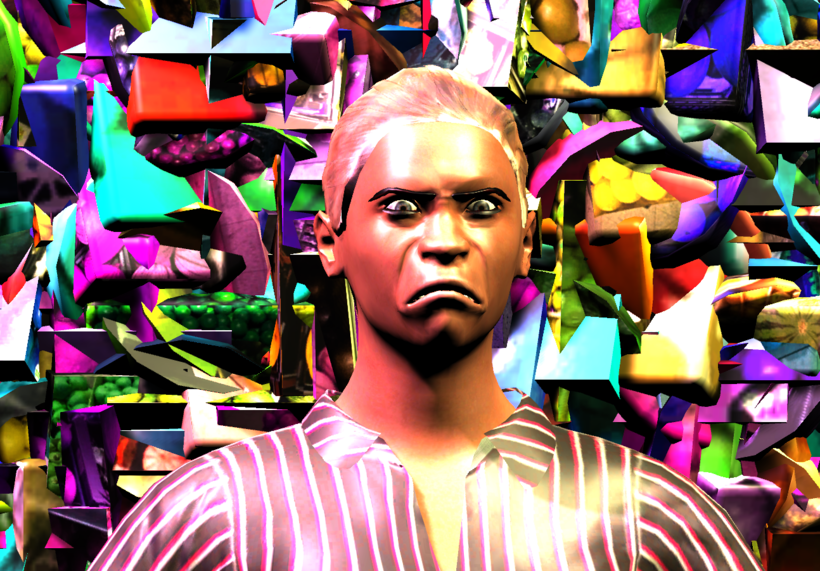

In [72]:
#show first picture in the angry folder
angry_faces = list(data_dir.glob('angry/*'))
PIL.Image.open(str(angry_faces[1]))

##Data Preprocessing

In [73]:
#define variable for later usage
batch_size = 32
img_height = 160
img_width = 160
image_size = (img_width, img_height)
print(image_size)

(160, 160)


train dataset

In [74]:
#Spilt train data set from the whole data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)

Found 1800 files belonging to 3 classes.
Using 1440 files for training.


Validation dataset

In [75]:
#Spilt validation data set from the whole data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)

Found 1800 files belonging to 3 classes.
Using 360 files for validation.


In [76]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names, num_classes)


['angry', 'crying', 'happy'] 3


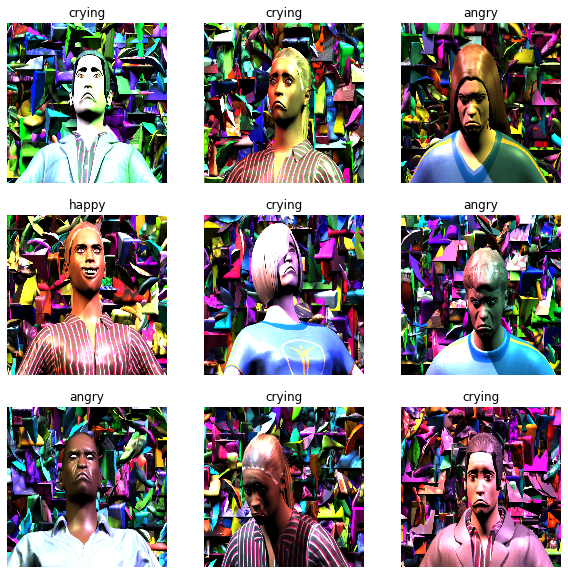

In [77]:
#display some data examples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [80]:
#show validation data set content
for image_batch, labels_batch in val_ds:
  print('#images, pixels-width, pixels-height, RGB color: ', image_batch.shape)
  print('label vector:', labels_batch)
  print('labels shape:', labels_batch.shape)
  break

#images, pixels-width, pixels-height, RGB color:  (32, 160, 160, 3)
label vector: tf.Tensor([2 0 1 2 1 0 1 0 0 2 1 2 1 0 1 2 1 2 2 0 2 1 1 0 2 1 1 1 2 1 0 2], shape=(32,), dtype=int32)
labels shape: (32,)


In [81]:
#show train data set content
for image_batch, labels_batch in train_ds:
  print('#images, pixels-width, pixels-height, RGB color: ', image_batch.shape)
  print('labels vector:', labels_batch)
  print('labels shape:', labels_batch.shape)
  break

#images, pixels-width, pixels-height, RGB color:  (32, 160, 160, 3)
labels vector: tf.Tensor([1 2 2 2 1 1 2 0 2 2 0 2 2 1 2 0 0 1 1 1 1 0 0 1 1 2 1 1 2 2 2 2], shape=(32,), dtype=int32)
labels shape: (32,)


### Create Test Data set


In [82]:
#don't click here twice
#spilt 20% of validation data to test set
val_batches = tf.data.experimental.cardinality(val_ds)
#Avoid create test_ds from val more than once
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 10
Number of test batches: 2


### Configure the dataset for performance


In [83]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Rescale Images


In [84]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [85]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 3. Create the base model from the pre-trained convnets

In [86]:
# Create the base model from the pre-trained model MobileNet V2
# 3 for RGB color so plue three here
image_shape = image_size + (3,)
print('input size', image_shape, image_size)
#include_top mean does not know the classisfication layer
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

input size (160, 160, 3) (160, 160)


In [87]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 4. Feature extraction

### Freeze the convolutional base

In [88]:
#set all nodes in the model are not trainable
base_model.trainable = False

### Important note about BatchNormalization layers***
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the Transfer learning guide.

In [89]:
# Take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [90]:
#first connection layer after the model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [91]:
#prediction (output) layer
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [92]:
#define model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
print(x.shape)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
print(outputs.shape)
model = tf.keras.Model(inputs, outputs)
model.summary()

(None, 160, 160, 3)
(None, 3)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              

In [93]:
#update binary cross entropy(0 or 1 only)to SparseCategoricalCrossentropy (1 or more classes)
#model.compile() config the model with losses and metrics
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
              metrics=['accuracy'])

In [94]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843

In [95]:
len(model.trainable_variables)

2

In [96]:


loss0, accuracy0 = model.evaluate(val_ds)

10/10 [==============================] - 9s 179ms/step - loss: 1.3648 - accuracy: 0.3172


In [97]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.38
initial accuracy: 0.30


In [101]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
#check init validation
initial_epochs = 100
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('Desktop/best_models/mobileNetv2_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#train with the datasets
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[es, mc])

Epoch 1/100
45/45 [==============================] - 34s 667ms/step - loss: 1.2226 - accuracy: 0.3674 - val_loss: 1.0915 - val_accuracy: 0.4493

Epoch 00001: val_accuracy improved from -inf to 0.44932, saving model to Desktop/best_models/mobileNetv2_model.h5
Epoch 2/100
45/45 [==============================] - 34s 667ms/step - loss: 1.1587 - accuracy: 0.4208 - val_loss: 1.0773 - val_accuracy: 0.4595

Epoch 00002: val_accuracy improved from 0.44932 to 0.45946, saving model to Desktop/best_models/mobileNetv2_model.h5
Epoch 3/100
45/45 [==============================] - 34s 665ms/step - loss: 1.1404 - accuracy: 0.4292 - val_loss: 1.0619 - val_accuracy: 0.4696

Epoch 00003: val_accuracy improved from 0.45946 to 0.46959, saving model to Desktop/best_models/mobileNetv2_model.h5
Epoch 4/100
45/45 [==============================] - 35s 686ms/step - loss: 1.1343 - accuracy: 0.4451 - val_loss: 1.0400 - val_accuracy: 0.4730

Epoch 00004: val_accuracy improved from 0.46959 to 0.47297, saving model

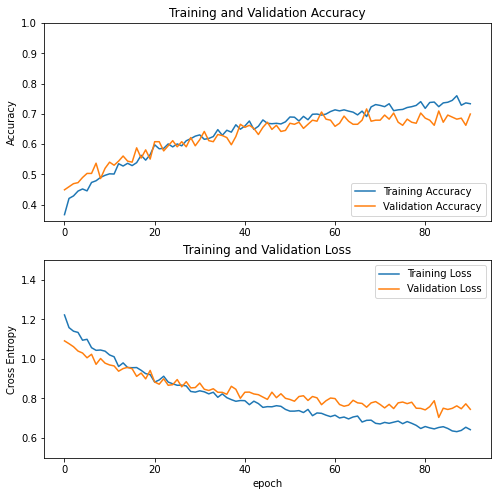

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.5,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


In [103]:
base_model.trainable = True

In [104]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model


In [105]:
#config the model again with new training parameter
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [106]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843

In [107]:
len(model.trainable_variables)

56

### Continue training the model

In [108]:
print(val_ds)
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[es, mc])
print(history.epoch[-1])

<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
Epoch 91/200
45/45 [==============================] - 39s 720ms/step - loss: 0.6463 - accuracy: 0.7291 - val_loss: 0.6866 - val_accuracy: 0.7196

Epoch 00091: val_accuracy improved from 0.71622 to 0.71959, saving model to Desktop/best_models/mobileNetv2_model.h5
Epoch 92/200
45/45 [==============================] - 36s 701ms/step - loss: 0.4832 - accuracy: 0.8003 - val_loss: 0.5590 - val_accuracy: 0.7838

Epoch 00092: val_accuracy improved from 0.71959 to 0.78378, saving model to Desktop/best_models/mobileNetv2_model.h5
Epoch 93/200
45/45 [==============================] - 36s 698ms/step - loss: 0.3917 - accuracy: 0.8543 - val_loss: 0.4920 - val_accuracy: 0.8041

Epoch 00093: val_accuracy improved from 0.78378 to 0.80405, saving model to Desktop/best_models/mobileNetv2_model.h5
Epoch 94/200
45/45 [==============================] - 36s 700ms/step - loss: 0.3479 - accuracy: 0.8685 - val_loss: 0.4385 -

In [109]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

100
0.349719762802124
[1.0915447473526, 1.0773212909698486, 1.0619007349014282, 1.0400187969207764, 1.0301467180252075, 1.0059666633605957, 1.023729681968689, 0.9727174043655396, 1.0022847652435303, 0.9788312911987305, 0.9697046875953674, 0.9648276567459106, 0.9379933476448059, 0.9513077735900879, 0.9577580094337463, 0.9504954218864441, 0.9119189381599426, 0.9286159873008728, 0.8993455171585083, 0.9419909119606018, 0.8834489583969116, 0.8722613453865051, 0.8998138904571533, 0.8668431639671326, 0.869841992855072, 0.8958470225334167, 0.8590443730354309, 0.8850484490394592, 0.8537548184394836, 0.8551915884017944, 0.8780157566070557, 0.8468634486198425, 0.8405638337135315, 0.8493401408195496, 0.8315439820289612, 0.8311866521835327, 0.8213483691215515, 0.8617277145385742, 0.8466881513595581, 0.8010628819465637, 0.831703782081604, 0.8323883414268494, 0.8229814171791077, 0.8193171620368958, 0.807295560836792, 0.795570969581604, 0.8320297002792358, 0.8041555285453796, 0.8239849209785461, 0.800

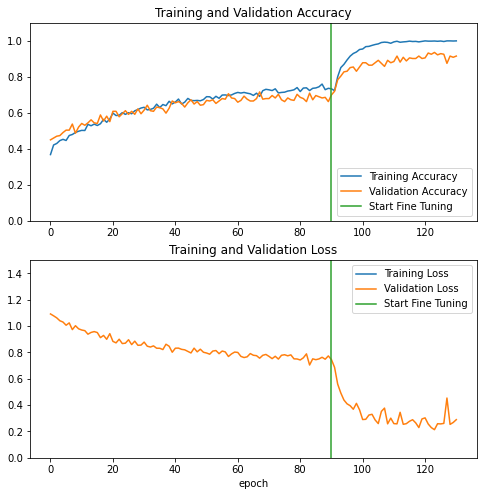

In [120]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.1])
print(initial_epochs)
plt.plot([history.epoch[-1],history.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
print(loss)
print(val_loss)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([history.epoch[-1],history.epoch[-1]],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [121]:
# from keras.models import load_model
# model = load_model('./drive/MyDrive/best_models/mobileNet_model.h5')
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

2/2 [==============================] - 5s 564ms/step - loss: 0.3482 - accuracy: 0.8750
Test accuracy : 0.875
Test loss: 0.3482140302658081


softmax Predictions:
 [[0.21194157 0.5761169  0.21194157]
 [0.21197292 0.21195534 0.57607174]
 [0.21194173 0.21194163 0.5761167 ]
 [0.2395267  0.54194266 0.2185307 ]
 [0.3418047  0.42649513 0.23170023]
 [0.21244453 0.2121343  0.57542115]
 [0.21194157 0.57611686 0.2119416 ]
 [0.21196695 0.2120246  0.5760085 ]
 [0.57593846 0.21203803 0.21202345]
 [0.21194158 0.21194157 0.57611686]
 [0.57611674 0.21194158 0.2119416 ]
 [0.5761154  0.21194242 0.2119421 ]
 [0.2119443  0.21194229 0.5761134 ]
 [0.24233897 0.5385435  0.21911745]
 [0.21884434 0.21373731 0.56741834]
 [0.21194626 0.21194296 0.57611084]
 [0.21194173 0.21194161 0.5761167 ]
 [0.21232717 0.21204434 0.5756285 ]
 [0.21712711 0.22515732 0.55771554]
 [0.21194768 0.5761091  0.2119432 ]
 [0.342741   0.23280323 0.4244557 ]
 [0.21194156 0.21194156 0.57611686]
 [0.5642049  0.2214182  0.2143769 ]
 [0.21194158 0.57611686 0.21194157]
 [0.23675077 0.39130095 0.3719482 ]
 [0.21194157 0.5761169  0.21194157]
 [0.5760872  0.21196502 0.21194787]
 [0.43

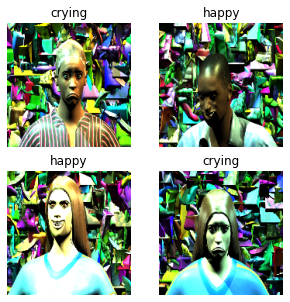

In [112]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
#print('Predictions on image :\n', len(predictions), predictions)

# Apply a soft max since our model returns logits (change to other activaton function)
predictions = tf.nn.softmax(predictions)
print('softmax Predictions:\n', predictions.numpy())

predictions = tf.argmax(predictions, axis=1)

print('Predictions class:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(5, 5))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  title = class_names[predictions[i]]
  if class_names[predictions[i]] != class_names[label_batch[i]]:
    title = title + " (Failed to predict " + class_names[label_batch[i]] + ")"
  plt.title(title)
  plt.axis("off")

In [137]:
from keras.models import load_model
model = load_model('Desktop/best_models/mobileNetv2_model.h5')
#define variable for later usage
# batch_size = 32
# img_height = 160
# img_width = 160
# image_size = (img_width, img_height)
# print(image_size)
#loss, accuracy = model.evaluate(test_ds)
#print('Test accuracy :', accuracy)
#print('Test loss:', loss)

import pathlib
dataset_path = "Desktop/real_data"

data_dir = pathlib.Path(dataset_path)
!ls {data_dir}
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)
loss, accuracy = model.evaluate(test_ds)


angry  crying  happy
Found 18 files belonging to 3 classes.
1/1 [==============================] - 1s 759ms/step - loss: 3.2633 - accuracy: 0.3333


softmax Predictions:
 [[0.57132375 0.2130427  0.2156336 ]
 [0.2140732  0.21250595 0.5734208 ]
 [0.39172882 0.28089377 0.32737747]
 [0.21993253 0.24453034 0.5355372 ]
 [0.21194285 0.2119419  0.5761152 ]
 [0.21766397 0.22213064 0.5602054 ]
 [0.5466909  0.22077303 0.2325361 ]
 [0.23243453 0.22453015 0.5430353 ]
 [0.21194735 0.57609165 0.211961  ]
 [0.21777616 0.546698   0.23552588]
 [0.21466604 0.5627407  0.2225933 ]
 [0.56196266 0.21599223 0.22204503]
 [0.21199104 0.21201691 0.57599205]
 [0.5739253  0.21240088 0.21367386]
 [0.22090456 0.24827293 0.5308225 ]
 [0.2177597  0.23595557 0.54628474]
 [0.4344396  0.23117799 0.3343824 ]
 [0.21195175 0.57609165 0.2119566 ]]
Predictions class:
 [0 2 0 2 2 2 0 2 1 1 1 0 2 0 2 2 0 1]
Labels:
 [1 0 0 0 0 0 1 1 1 2 2 0 2 2 1 2 2 1]


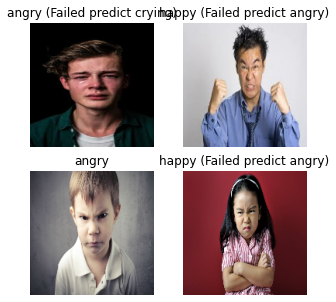

In [138]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
#print('Predictions on image :\n', len(predictions), predictions)

# Apply a soft max since our model returns logits (change to other activaton function)
predictions = tf.nn.softmax(predictions)
print('softmax Predictions:\n', predictions.numpy())

predictions = tf.argmax(predictions, axis=1)

print('Predictions class:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(5, 5))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  title = class_names[predictions[i]]
  if class_names[predictions[i]] != class_names[label_batch[i]]:
    title = title + " (Failed predict " + class_names[label_batch[i]] + ")"
  plt.title(title)
  plt.axis("off")